In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.insert(0, ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Path to Shapes trained weights
SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_shapes.h5")

Using TensorFlow backend.


In [2]:
### Run one of the code blocks

# Shapes toy dataset
# import shapes
# config = shapes.ShapesConfig()

# MS COCO Dataset
import coco_pose
config = coco_pose.CocoPoseConfig()
COCO_DIR = "/media/funes/Box/babino/coco"  # TODO: enter value here


In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NAME = 'cocoresnetoho'
    TRAIN_ROIS_PER_IMAGE = 1000

config = InferenceConfig()
#config.NAME = 'cocoresnetoho'
config.NAME = 'cocoresnetft'
config.BACKBONE = "resnet50"
#config.NAME = 'coco'
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CLASSES_WITH_KP                [1]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
KEYPOINT_MASK_SHAPE            [56, 56]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mr

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [6]:
# Build validation dataset
if config.NAME == 'shapes':
    dataset = shapes.ShapesDataset()
    dataset.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
elif config.NAME.startswith("coco"):
    dataset = coco_pose.CocoPoseDataset()
    dataset.load_coco(COCO_DIR, "minival")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))
print(config.NAME)

loading annotations into memory...


FileNotFoundError: [Errno 2] No such file or directory: '/media/funes/Box/babino/coco/annotations/person_keypoints_minival2014.json'

In [24]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

use_last_or_coco = 'last'
# Set weights file path
if config.NAME == "shapes":
    weights_path = SHAPES_MODEL_PATH
elif config.NAME == "coco":
    weights_path = COCO_MODEL_PATH


if use_last_or_coco=='last':
    # Or, uncomment to load the last model you trained
    weights_path = model.find_last()
    print("Loading weights ", weights_path)
    # Load weights
    model.load_weights(weights_path, by_name=True)
elif use_last_or_coco == 'coco':
    print("Loading weights ", COCO_MODEL_PATH)
    #model.load_weights(COCO_MODEL_PATH, by_name=True,
    #                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
    #                            "mrcnn_bbox", "mrcnn_mask"])    
    model.load_weights(COCO_MODEL_PATH, by_name=True)
    #                  exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
    #                           "mrcnn_mask"])    #"mrcnn_bbox", 
    #mrcnn_class_logits: Dimension 1 in both shapes must be equal, but are 2 and 81 for 'Assign_6156' (op: 'Assign') with input shapes: [1024,2], [1024,81].
    #"mrcnn_bbox_fc": ValueError: Dimension 1 in both shapes must be equal, but are 8 and 324 for 'Assign_6839' (op: 'Assign') with input shapes: [1024,8], [1024,324].
    #mrcnn_mask: ValueError: Dimension 3 in both shapes must be equal, but are 2 and 81 for 'Assign_7524' (op: 'Assign') with input shapes: [1,1,256,2], [1,1,256,81].

Loading weights  /home/andres/Documents/ababino_Mask_RCNN/logs/cocoresnetft20191009T1216/mask_rcnn_cocoresnetft_0140.h5
Re-starting from epoch 140


## Run Detection

image ID: coco.336356 (156) http://cocodataset.org/#explore?id=336356
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


/home/andres/Documents/ababino_Mask_RCNN/mrcnn/utils.py:667: RuntimeWarning: divide by zero encountered in true_divide
  kp_mask_softmax = kp_mask_exp / partition
/home/andres/Documents/ababino_Mask_RCNN/mrcnn/utils.py:667: RuntimeWarning: invalid value encountered in true_divide
  kp_mask_softmax = kp_mask_exp / partition
/home/andres/Documents/ababino_Mask_RCNN/mrcnn/utils.py:668: RuntimeWarning: invalid value encountered in less
  below_th_mask = kp_mask_softmax < threshold


kp_mask shape (1024, 1024, 17, 5)
gt_class_id              shape: (4,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (4, 4)                min:   22.00000  max:  733.00000  int32
gt_mask                  shape: (1024, 1024, 4)       min:    0.00000  max:    1.00000  bool


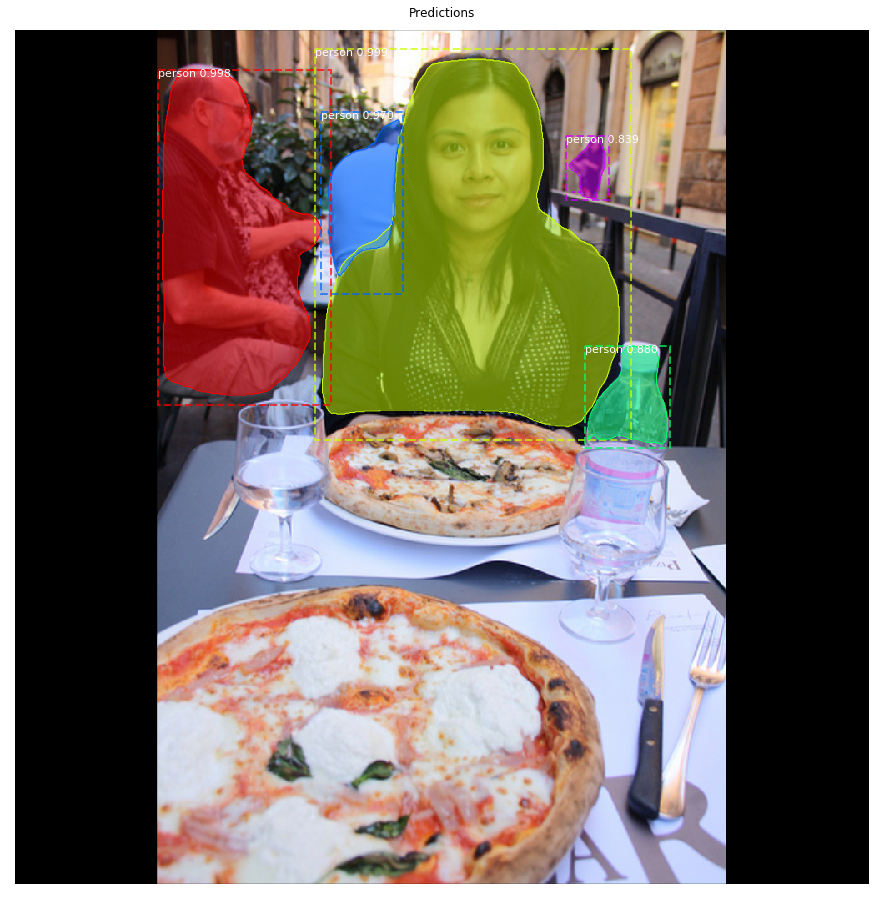

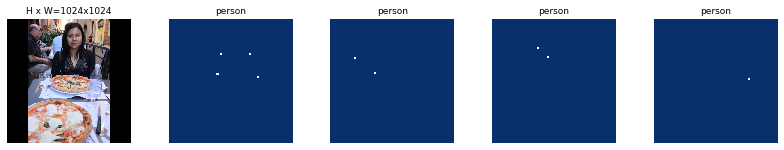

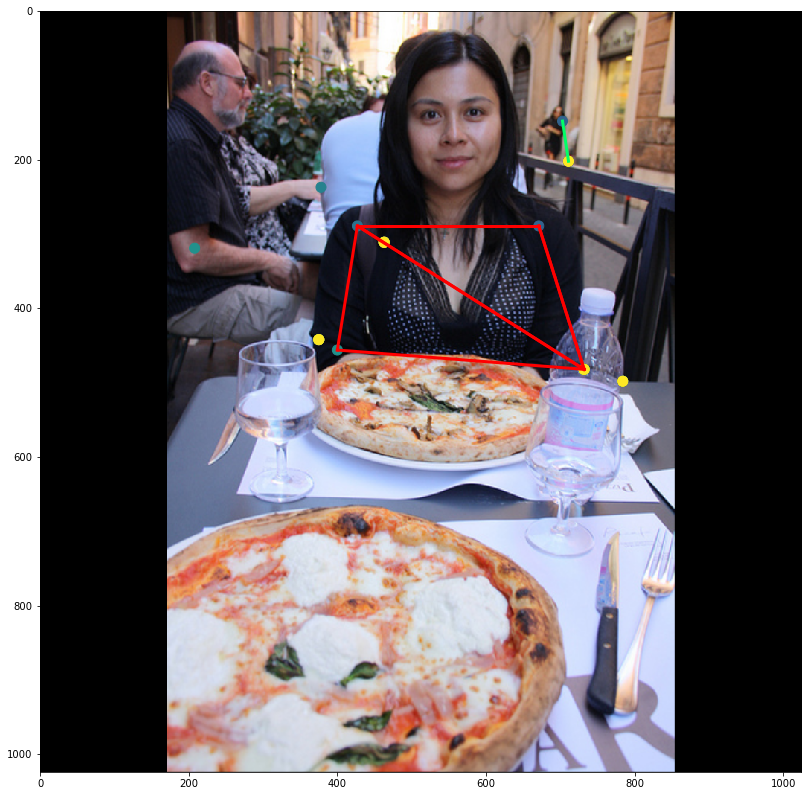

In [36]:
image_id = random.choice(dataset.image_ids)
np.set_printoptions(precision=1, linewidth=175)
#np.core.arrayprint._line_width = 180
#image_id = 916
image, image_meta, gt_class_id, gt_bbox, gt_mask, keypoint_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)
# Display results
ax = get_ax(1)
r = results[0]
print('kp_mask shape', r['kp_masks'].shape)
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
#a += r['kp_masks'].sum(axis=(0,1,3))
#print('kpoints:....', r['kp_masks'].sum(axis=(0,1,3)))
#print('kpoints  acum:....', a)
visualize.display_top_keypoint_masks(image, r['kp_masks'], r['class_ids'], dataset.class_names)
skeleton = dataset.class_info[1]['skeleton']
visualize.display_skeletons_from_keypoint_masks(image, r['kp_masks'], skeleton)

i, j, k, n = np.where(r['kp_masks'])
plt.scatter(j, i, s=100, c=k)

image ID: coco.469067 (698) http://cocodataset.org/#explore?id=469067
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  239.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  126.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:    0.00000  max:  891.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool
kp_masks                 shape: (1024, 1024, 19, 1)   min:    0.00000  max:    1.00000  bool
17
0


/home/andres/Documents/ababino_Mask_RCNN/mrcnn/visualize.py:55: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  norm=norm, interpolation=interpolation)
/home/andres/Documents/ababino_Mask_RCNN/mrcnn/visualize.py:55: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  norm=norm, interpolation=interpolation)


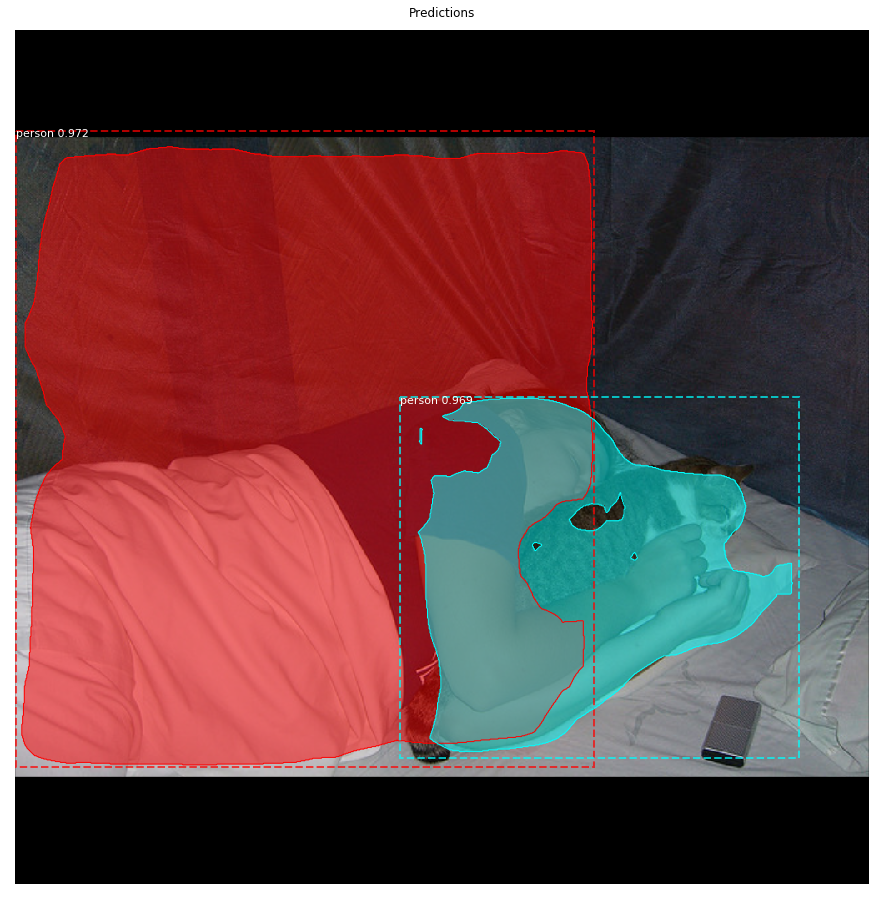

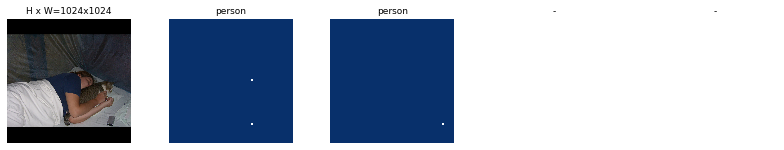

len skeleton 19


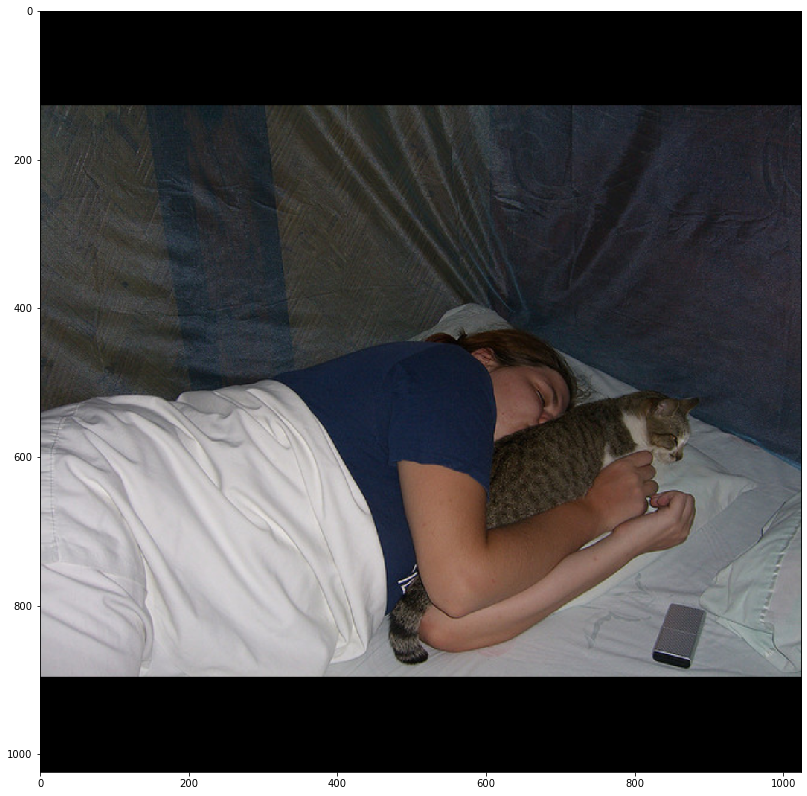

In [79]:
#image_id = 696
image_id = random.choice(dataset.image_ids)
np.set_printoptions(precision=1, linewidth=175)
#np.core.arrayprint._line_width = 180
#image_id = 916
image, image_meta, gt_class_id, gt_bbox, gt_mask, keypoint_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)
# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
log("kp_masks", keypoint_mask)
print(len(dataset.class_info[1]['keypoints']))
print(keypoint_mask[:,:,16:,:].sum())
visualize.display_top_keypoint_masks(image, r['kp_masks'], r['class_ids'], dataset.class_names)
skeleton = dataset.class_info[1]['skeleton']
print('len skeleton', len(skeleton))
visualize.display_skeletons_from_keypoint_masks(image, r['kp_masks'], skeleton)


In [52]:
skeleton
dataset.class_info[1]['keypoints']
kpn = 17
(i, j) = np.where(r['kp_masks'][:,:,kpn,0])
if i:
    print(dataset.class_info[1]['keypoints'][kpn],i[0], j[0])
else:
    print('no', dataset.class_info[1]['keypoints'][kpn])
plt.figure(figsize=[20, 20])
plt.imshow(image)
plt.scatter(j, i, s=100)
print(len(dataset.class_info[1]['keypoints']))

IndexError: index 17 is out of bounds for axis 2 with size 17

In [17]:
visualize.display_instances(image, r['rois'][:5], r['masks'][:5], r['class_ids'][:5], 
                            dataset.class_names, r['scores'][:5], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

#visualize.display_top_keypoint_masks(image, r['kp_masks'][:5], r['class_ids'][:5], dataset.class_names)
#skeleton = dataset.class_info[1]['skeleton']
#visualize.display_skeletons_from_keypoint_masks(image, r['kp_masks'][:5], skeleton)

AssertionError: 

In [10]:
r['scores']

array([1., 1.], dtype=float32)

In [10]:
r['masks'].shape

(1024, 1024, 5)

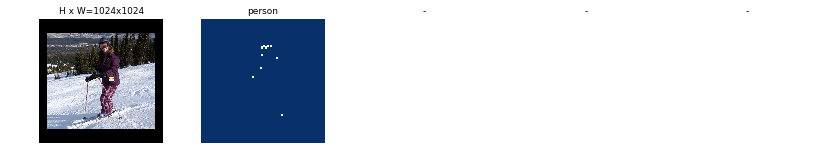

10

In [17]:
#visualize.display_skeletons(image, r['kp_masks'])
#keypoint_mask, class_ids = dataset.load_keypoint_mask(image_id)
visualize.display_top_keypoint_masks(image, r['kp_masks'], r['class_ids'], dataset.class_names)
r['kp_masks'].sum()

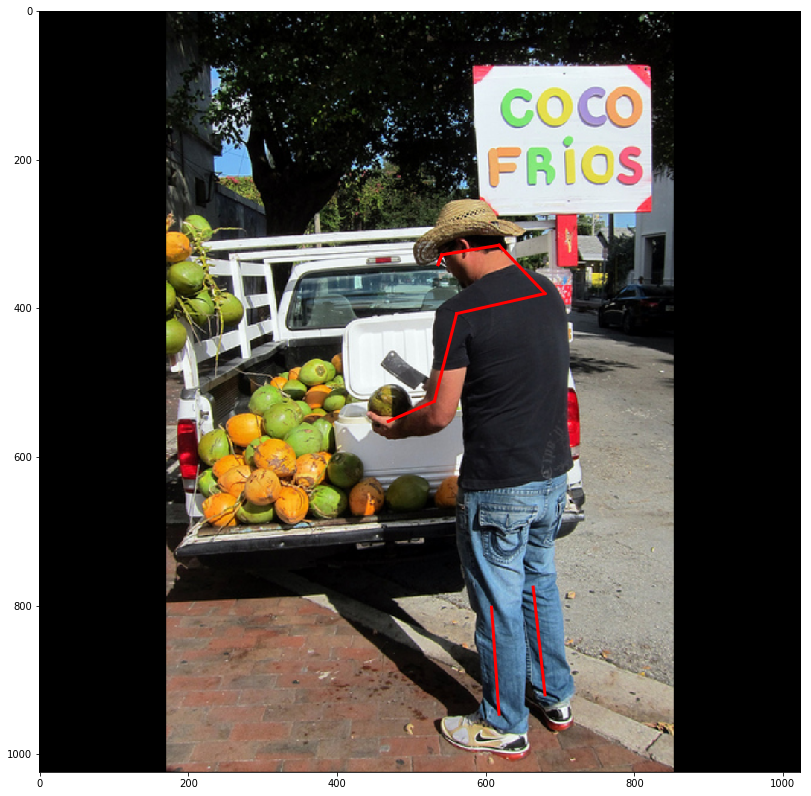

In [21]:
skeleton = dataset.class_info[1]['skeleton']
visualize.display_skeletons_from_keypoint_masks(image, r['kp_masks'], skeleton)

In [13]:
skeleton = dataset.class_info[1]['skeleton']
height, width, num_keypoints, N = kp_masks.shape
kp_masks = r['kp_masks']
i = 0
pepe = np.argmax(kp_masks[:,:,:,i].reshape((height * width, num_keypoints)), axis=0)
x, y = np.unravel_index(pepe, (height, width))
x
y

NameError: name 'kp_masks' is not defined

In [ ]:
np.max(np.array([False, False]))